**GRID WORLD Environment with experience replay in DQN, Target network, Q function as qˆ(s, w)**


In [23]:
import gym, math, random
from collections import namedtuple, deque
import matplotlib
from itertools import count
from PIL import Image
from collections import deque
import random
from collections import defaultdict
import numpy
import pandas as pd
import pickle
from gym import spaces
from itertools import cycle
from gym.spaces.discrete import Discrete
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")      
device = get_device()
print("Selected Device is : ",device)

Selected Device is :  cpu


In [24]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity=capacity
        self.memory = deque([], self.capacity)

    def add(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        dict_keys = ["state", "action", "reward", "next_state", "done"]
        sample_dicts = []
        for sample in random.sample(self.memory, batch_size):
            sample_dict = {}
            for key, value in zip(dict_keys, sample):
                sample_dict[key] = value
            sample_dicts.append(sample_dict)
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [25]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len,
                 action_space_len):
        super(DQN, self).__init__()
        self.state_space_len=state_space_len
        self.action_space_len=action_space_len
        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc2(x))
      return self.fc4(x)

    def sample_action(self, obs, epsilon):
        if torch.rand(1).item() < epsilon:
            return random.randint(0, self.action_space_len - 1)
        else:
            q_values = self.forward(obs)
            return q_values.argmax().item()

In [26]:
class GridEnvironment(gym.Env):
    
    def __init__(self, max_timesteps):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.candy_pos = np.asarray([1, 2])
        self.rewardthree=[3,1]
        self.diamond_pos = np.asarray([2, 1])
        self.reward_pos=np.asarray([2, 2])
        self.gold_collected = 0
        self.reward_collected = 0
        self.candy_collected = 0
        self.diamond_collected = 0      
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 2])
        self.rewardfour=0.33
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.rewardthree=0.22
        self.state[tuple(self.goal_pos)] = 0.5
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.state[tuple(self.candy_pos)] = 0.23
        self.state[tuple(self.reward_pos)] = 0.24
        self.epsilon = 0.9
        self.state[tuple(self.diamond_pos)] = 0.22

        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.asarray([0, 0])
        self.state = np.zeros((4, 4))
        self.reward_collected = 0
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.agent_pos)] = 1
        self.gold_collected = 0
        self.candy_collected = 0
        self.diamond_collected = 0
        observation = self.state.flatten()
        self.goal_pos = np.asarray([3, 2])        
        return observation
    
    def step(self, action: int):      
        reward = -1
        terminal_state_reached = False
        if action == 0:
            self.agent_pos[1] += 1 # right
        elif action == 1:
          self.agent_pos[0] += 1 # down
        elif action == 3:
          self.agent_pos[0] -= 1 # up
        elif action == 2:
          self.agent_pos[1] -= 1 # left
        else:
            print("Illiegal Action Taken Mr. Agent, No Games !!")
            return
          
        self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.reward_pos)] = 0.24
        self.state[tuple(self.goal_pos)] = 0.5
        self.rewardThree=[3,3]
        self.state[tuple(self.candy_pos)] = 0.23
        self.state[tuple(self.diamond_pos)] = 0.22
        observation = self.state.flatten()
    
        if (self.agent_pos == self.goal_pos).all():
            terminal_state_reached = True
            if (self.gold_collected==0):
              reward = 10
              self.gold_collected = -1
                
        if (self.agent_pos == self.reward_pos).all():
            if (self.reward_collected==0):
              reward = 2
              self.reward_collected = -1
                
        if (self.agent_pos == self.candy_pos).all():
          if (self.candy_collected==0):
              reward = 5
              self.candy_collected = -1

        if (self.agent_pos == self.diamond_pos).all():
          if (self.diamond_collected==0):
              reward = -3
              self.diamond_collected = -1
                   
        self.timestep = self.timestep + 1       
        if self.timestep > self.max_timesteps or terminal_state_reached:
            done = True
        else:
            done = False        
        info = {}
        return observation, reward, done,terminal_state_reached, action


    def render(self):
        plt.figure()
        plt.imshow(self.state)

In [27]:
Q_primary_next_state=0
Q_optimal_next_state=0
def train_step():
    merged_dict = {}
    batch = memory.sample(BATCH_SIZE)
    for key in batch[0].keys():
        merged_dict[key] = []
    for d in batch:
        for key, value in d.items():
            merged_dict[key].append(value)
    batch = merged_dict
    # we are not catching the gradients
    with torch.no_grad():
        Q_primary_next_state = primary_net(torch.FloatTensor(np.array(batch.get("next_state"))).to(device))
        max_Q_primary_next_state_action = torch.argmax(Q_primary_next_state, dim=1, keepdim=True)
    with torch.no_grad():
        Q_optimal_next_state = target_net(torch.FloatTensor(np.array(batch.get("next_state"))).to(device))
        max_Q_optimal_next_state = Q_optimal_next_state.gather(1, max_Q_primary_next_state_action)
        Q_optimal = torch.FloatTensor(np.array(batch.get("reward"))).unsqueeze(1).to(device) + GAMMA * max_Q_optimal_next_state * torch.FloatTensor(np.array(batch.get("done"))).unsqueeze(1).to(device)

    print(Q_primary_next_state,Q_optimal_next_state)
    Q_primary = primary_net(torch.FloatTensor(np.array(batch.get("state"))).to(device)).gather(1, torch.LongTensor(np.array(batch.get("action"))).unsqueeze(1).to(device))
    criterion = nn.SmoothL1Loss()
    loss = criterion(Q_optimal, Q_primary)
    optimizer.zero_grad()
    loss.backward()
    for param in primary_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


Streaming output truncated to the last 5000 lines.
        [ 7.3457,  5.4011,  5.3214,  5.8056],
        [ 6.1109, 10.5198,  5.7382,  8.0088],
        [ 6.0121, 10.3772,  6.8491,  7.9806],
        [ 7.3457,  5.4011,  5.3214,  5.8056],
        [ 8.1921,  8.2754,  6.3043,  6.4334],
        [ 9.9175,  6.9329,  5.7501,  7.3379],
        [ 6.0121, 10.3772,  6.8491,  7.9806],
        [ 8.1921,  8.2754,  6.3043,  6.4334],
        [13.7009,  6.5511,  7.8263,  8.5716]])
tensor([[10.7189,  5.9231,  8.1716,  6.1147],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 6.2583, 10.7744,  6.0806,  7.9012],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 7.4559,  5.2661,  5.3453,  5.6181],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 6.1677, 10.4069,  7.0090,  7.7521],
        [ 6.2583, 10.7744,  6.0806,  7.9012],
        [13.8543,  6.2989,  

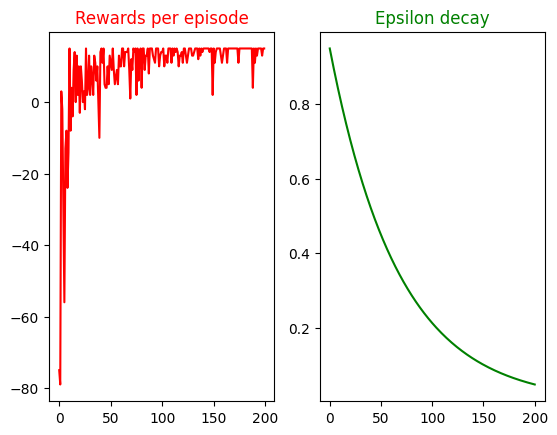

In [28]:
env = GridEnvironment(max_timesteps=100)

rewards_per_episode = []
BATCH_SIZE = 16
GAMMA = 0.85 #0.999
epsilon_per_episode = []
TARGET_UPDATE = 10
num_episodes = 200
epsilon = 0.95
decay_factor = math.pow((0.05 / 1),(1/num_episodes))
epsilon_per_episode.append(epsilon)
memory = ReplayMemory(5120) # <10000
Discrete
n_actions = env.action_space.n
#print(env.observation_space)
primary_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=1e-3)


curr_episode_reward = 0
steps_done = 0

state = env.reset()

for i_episode in range(num_episodes): 
    for t in range (1024):
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) 
        next_state, reward, done, terminal_state_reached,_ = env.step(action)
        if(curr_episode_reward < 2048):
            curr_episode_reward = curr_episode_reward+  reward
            
        memory.add([state, action,reward,next_state,not terminal_state_reached])
       
        if (len(memory)>BATCH_SIZE and BATCH_SIZE<300):
          train_step()
        if (not done):
            state = next_state
        else:
            break
    
    if i_episode % TARGET_UPDATE == 0 and i_episode != 0: target_net.load_state_dict(primary_net.state_dict())    
    epsilon = epsilon * decay_factor
    rewards_per_episode.append(curr_episode_reward)
    epsilon_per_episode.append(epsilon)
    epsilon * decay_factor
    curr_episode_reward = 0
    
    state = env.reset()

    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Rewards per episode',color="red")
ax1.plot(rewards_per_episode,color="red")
ax2.set_title('Epsilon decay',color="green")
ax2.plot(epsilon_per_episode,color="green")
plt.show()

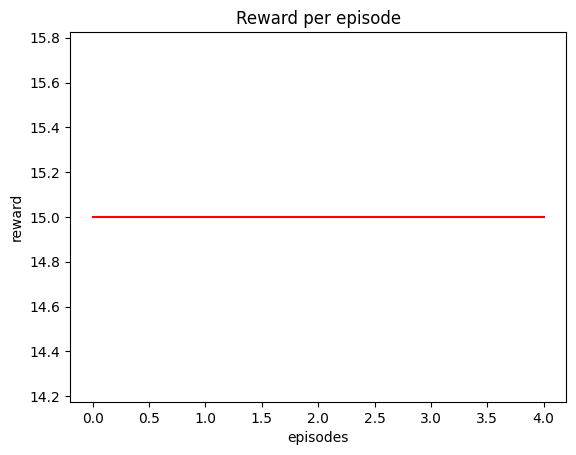

In [29]:
eval_epsiodes = 5
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    for t in range (1024):  
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)
        next_state, reward, done, terminal_state_reached = env.step(action)[:4]
        curr_episode_reward =curr_episode_reward+ reward
        if done:
            break   
        state = next_state
    rewards_per_episode.append(curr_episode_reward)

plt.ylabel('reward')
plt.xlabel('episodes')
plt.title("Reward per episode")
plt.plot(rewards_per_episode, color="red")
plt.show()

In [30]:
print(memory)

In [31]:
showASampleBuffer=memory.sample(BATCH_SIZE)[0]
print(showASampleBuffer)

{'state': array([0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.23, 0.  , 0.  , 0.22, 0.24,
       0.  , 0.  , 0.  , 0.5 , 0.  ]), 'action': 2, 'reward': -1, 'next_state': array([0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.23, 0.  , 0.  , 0.22, 0.24,
       0.  , 0.  , 0.  , 0.5 , 0.  ]), 'done': True}


In [32]:
prime_net=primary_net
target_net=target_net
print("action from Traget Network :",target_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) )

action from Traget Network : 1


In [33]:
print("action from Primary Network :",prime_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) )

action from Primary Network : 1


In [34]:
print(Q_primary_next_state,Q_optimal_next_state)

0 0


In [35]:
pickle.dump([showASampleBuffer,Q_primary_next_state,Q_optimal_next_state,"action from Traget Network :",target_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) ], open('giridworldDQN.pkl', 'wb'))

In [36]:
file = open('giridworldDQN.pkl', 'rb')
print(pickle.load(file))

[{'state': array([0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.23, 0.  , 0.  , 0.22, 0.24,
       0.  , 0.  , 0.  , 0.5 , 0.  ]), 'action': 2, 'reward': -1, 'next_state': array([0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.23, 0.  , 0.  , 0.22, 0.24,
       0.  , 0.  , 0.  , 0.5 , 0.  ]), 'done': True}, 0, 0, 'action from Traget Network :', 1]


**Grid World Double DQN**

Grid_world Environment with experience replay, Target network, Q function as qˆ(s, w) using Double DQN


In [37]:
import gym, math, random
from collections import namedtuple, deque
import matplotlib
from itertools import count
from PIL import Image
from collections import deque
import random
from collections import defaultdict
import numpy
import pandas as pd
import pickle
from gym import spaces
from itertools import cycle
from gym.spaces.discrete import Discrete
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.functional as F

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")      
device = get_device()
print("Selected Device is : ",device)

Selected Device is :  cpu


In [38]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity=capacity
        self.memory = deque([], self.capacity)

    def add(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        dict_keys = ["state", "action", "reward", "next_state", "done"]
        sample_dicts = []
        for sample in random.sample(self.memory, batch_size):
            sample_dict = {}
            for key, value in zip(dict_keys, sample):
                sample_dict[key] = value
            sample_dicts.append(sample_dict)
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [39]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len,
                 action_space_len):
        super(DQN, self).__init__() 
        self.state_space_len=state_space_len
        self.action_space_len=action_space_len
        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc2(x))
      return self.fc4(x)

    def sample_action(self, obs, epsilon):
        if torch.rand(1).item() < epsilon:
            return random.randint(0, self.action_space_len - 1)
        else:
            q_values = self.forward(obs)
            return q_values.argmax().item()   

In [40]:
class GridEnvironment(gym.Env):
    
    def __init__(self, max_timesteps):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.candy_pos = np.asarray([1, 2])
        self.rewardthree=[3,1]
        self.diamond_pos = np.asarray([2, 1])
        self.reward_pos=np.asarray([2, 2])
        self.gold_collected = 0
        self.reward_collected = 0
        self.candy_collected = 0
        self.diamond_collected = 0     
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 2])
        self.rewardfour=0.33
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.rewardthree=0.22
        self.state[tuple(self.goal_pos)] = 0.5
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.state[tuple(self.candy_pos)] = 0.23
        self.state[tuple(self.reward_pos)] = 0.24
        self.epsilon = 0.9
        self.state[tuple(self.diamond_pos)] = 0.22
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.asarray([0, 0])
        self.state = np.zeros((4, 4))
        self.reward_collected = 0
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.agent_pos)] = 1
        self.gold_collected = 0
        self.candy_collected = 0
        self.diamond_collected = 0
        observation = self.state.flatten()
        self.goal_pos = np.asarray([3, 2])        
        return observation
    
    def step(self, action: int):   
        reward = -1
        terminal_state_reached = False
        if action == 0:
            self.agent_pos[1] += 1 # right
        elif action == 1:
          self.agent_pos[0] += 1 # down
        elif action == 3:
          self.agent_pos[0] -= 1 # up
        elif action == 2:
          self.agent_pos[1] -= 1 # left
        else:
            print("Illiegal Action Taken Mr. Agent, No Games !!")
            return
          
        self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.reward_pos)] = 0.24
        self.state[tuple(self.goal_pos)] = 0.5
        self.rewardThree=[3,3]
        self.state[tuple(self.candy_pos)] = 0.23
        self.state[tuple(self.diamond_pos)] = 0.22
        observation = self.state.flatten()
        if (self.agent_pos == self.goal_pos).all():
            terminal_state_reached = True
            if (self.gold_collected==0):
              reward = 10
              self.gold_collected = -1              
        if (self.agent_pos == self.reward_pos).all():
            if (self.reward_collected==0):
              reward = 2
              self.reward_collected = -1                
        if (self.agent_pos == self.candy_pos).all():
          if (self.candy_collected==0):
              reward = 5
              self.candy_collected = -1
        if (self.agent_pos == self.diamond_pos).all():
          if (self.diamond_collected==0):
              reward = -3
              self.diamond_collected = -1            
        self.timestep = self.timestep + 1
        
        if self.timestep > self.max_timesteps or terminal_state_reached:
            done = True
        else:
            done = False       
        info = {}      
        return observation, reward, done,terminal_state_reached, action

    def render(self):
        plt.figure()
        plt.imshow(self.state)

In [41]:
Q_primary_next_state=0
Q_optimal_next_state=0

def train_step(t):
   
    merged_dict = {}
    batch = memory.sample(BATCH_SIZE)
    for key in batch[0].keys():
        merged_dict[key] = []
    for d in batch:
        for key, value in d.items():
            merged_dict[key].append(value)
    batch = merged_dict
    with torch.no_grad():
        Q_primary_next_state = primary_net(torch.FloatTensor(np.array(batch.get("next_state"))).to(device))
        max_Q_primary_next_state_action = torch.argmax(Q_primary_next_state, dim=1, keepdim=True)
    with torch.no_grad():
        Q_optimal_next_state = target_net(torch.FloatTensor(np.array(batch.get("next_state"))).to(device))
        max_Q_optimal_next_state_action = torch.argmax(Q_optimal_next_state, dim=1, keepdim=True)
        max_Q_optimal_next_state = Q_optimal_next_state.gather(1, max_Q_primary_next_state_action)
    Q_optimal = torch.FloatTensor(np.array(batch.get("reward"))).unsqueeze(1).to(device) + GAMMA * max_Q_optimal_next_state * torch.FloatTensor(np.array(batch.get("done"))).unsqueeze(1).to(device)
    Q_primary = primary_net(torch.FloatTensor(np.array(batch.get("state"))).to(device)).gather(1, torch.LongTensor(np.array(batch.get("action"))).unsqueeze(1).to(device))
    criterion = nn.SmoothL1Loss()
    loss = criterion(Q_optimal, Q_primary)
    optimizer.zero_grad()
    loss.backward()
    for param in primary_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    if ((t+1) % TARGET_UPDATE) == 0:
        target_net.load_state_dict(primary_net.state_dict())

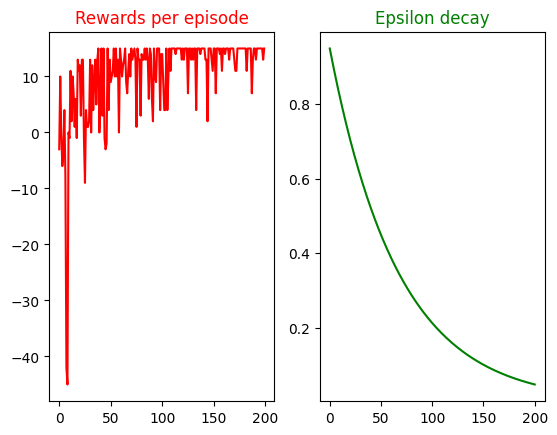

In [42]:
env = GridEnvironment(max_timesteps=100)

rewards_per_episode = []
BATCH_SIZE = 16
GAMMA = 0.85 #0.999
epsilon_per_episode = []
TARGET_UPDATE = 10
num_episodes = 200
epsilon = 0.95
decay_factor = math.pow((0.05 / 1),(1/num_episodes))
epsilon_per_episode.append(epsilon)
memory = ReplayMemory(5120) # <10000
Discrete
n_actions = env.action_space.n
#print(env.observation_space)
primary_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net = DQN(env.observation_space.n,env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=1e-3)

curr_episode_reward = 0
steps_done = 0

state = env.reset()

for i_episode in range(num_episodes): 
    for t in range (1024):
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) 
        next_state, reward, done, terminal_state_reached,_ = env.step(action)
        if(curr_episode_reward < 2048):
            curr_episode_reward = curr_episode_reward+  reward            
        memory.add([state, action,reward,next_state,not terminal_state_reached])
       
        if (len(memory)>BATCH_SIZE and BATCH_SIZE<300):
          train_step(t)
        if (not done):
            state = next_state
        else:
            break
    
    if i_episode % TARGET_UPDATE == 0 and i_episode != 0: target_net.load_state_dict(primary_net.state_dict())

        
    epsilon = epsilon * decay_factor
    rewards_per_episode.append(curr_episode_reward)
    epsilon_per_episode.append(epsilon)
    epsilon * decay_factor
    curr_episode_reward = 0
    
    state = env.reset()

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Rewards per episode',color="red")
ax1.plot(rewards_per_episode,color="red")
ax2.set_title('Epsilon decay',color="green")
ax2.plot(epsilon_per_episode,color="green")
plt.show()

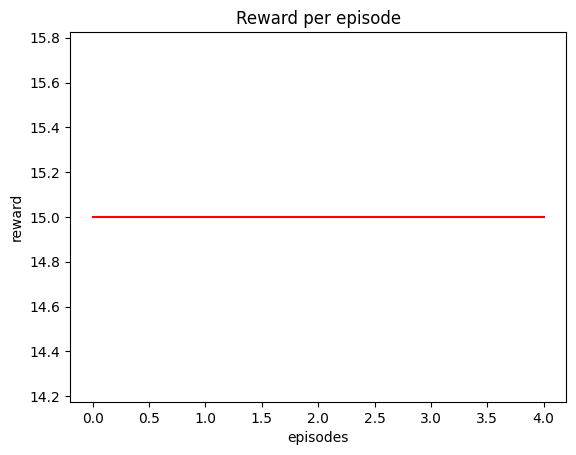

In [43]:
eval_epsiodes = 5
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0    
    for t in range (1024):  
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)
        next_state, reward, done, terminal_state_reached = env.step(action)[:4]
        curr_episode_reward =curr_episode_reward+ reward
        if done:
            break       
        state = next_state
    rewards_per_episode.append(curr_episode_reward)

plt.ylabel('reward')
plt.xlabel('episodes')
plt.title("Reward per episode")
plt.plot(rewards_per_episode, color="red")
plt.show()

In [44]:
print(memory)

In [45]:
showASampleBuffer=memory.sample(BATCH_SIZE)[0]
print(showASampleBuffer)

{'state': array([0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.  , 0.22, 0.24,
       0.  , 0.  , 0.  , 0.5 , 0.  ]), 'action': 1, 'reward': -1, 'next_state': array([0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.23, 0.  , 0.  , 0.22, 0.24,
       0.  , 0.  , 0.  , 0.5 , 0.  ]), 'done': True}


In [46]:
prime_net=primary_net
target_net=target_net

print("action from Traget Network :",target_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) )

action from Traget Network : 1


In [47]:
print("action from Primary Network :",prime_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) )

action from Primary Network : 1


In [48]:
print(Q_primary_next_state,Q_optimal_next_state)

0 0


In [49]:
pickle.dump([memory,showASampleBuffer,target_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)],open('gridworldDDQN.pkl', 'wb'))

**CartPolve-v1**


In [50]:
!pip install gym[classic_control]
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import matplotlib
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1')

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")      
device = get_device()
print("Selected Device is : ",device)

Selected Device is :  cpu


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [52]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, action_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [53]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = ["state", "action", "reward", "next_state", "done"]
    
    def add(self, state, action, reward, next_state, done):
        experience = [state, action, reward, next_state, done]
        self.memory.append(experience)
                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[0])
        states = torch.from_numpy(np.array(tempTensor)).float().to(device)
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[1]])
        actions = torch.from_numpy(np.array(tempTensor)).long().to(device)  
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[2]])
        rewards = torch.from_numpy(np.array(tempTensor)).float().to(device) 
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[3])
        next_states = torch.from_numpy(np.array(tempTensor)).float().to(device)  

        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[4]])
        dones = torch.from_numpy(np.array(tempTensor).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [54]:
BUFFER_SIZE = int(1e5)  # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

class DQNAgent:
    def __init__(self):
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.fixed_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.timestep = 1
  
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if ((self.timestep-1) % UPDATE_EVERY) == 0:
            if len(self.memory) > BATCH_SIZE:
                self.learn(self.memory.sample())
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        action_values = self.fixed_network(next_states).detach()
        Q_target = rewards + (GAMMA * action_values.max(1)[0].unsqueeze(1) * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.fnetwork_update(self.q_network, self.fixed_network)
        
    def fnetwork_update(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            with torch.no_grad():
                target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)    
        
    def act(self, state, eps):
        if random.random() < eps:
            return np.random.randint(action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    


In [55]:
BUFFER_SIZE = int(1e5) 
BATCH_SIZE = 64         
GAMMA = 0.99            
TAU = 1e-3              
LR = 1e-4               
UPDATE_EVERY = 4        

In [56]:
MAX_EPISODES = 3000  
EPS_START = 1      
EPS_DECAY = 0.999    
EPS_MIN = 0.01       

In [57]:
dqn_agent = DQNAgent()

In [58]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(2500):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if score >= 550:
            break
            
    scores_window.append(score)
    scores.append(score)

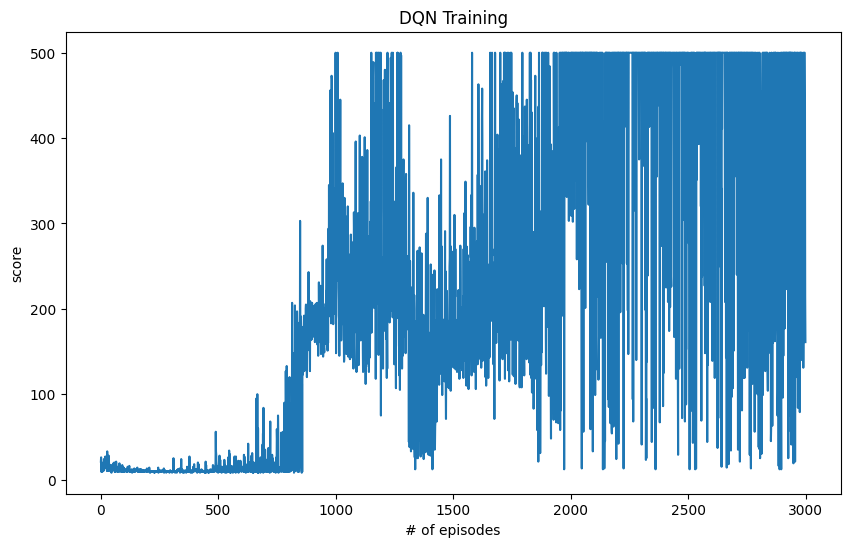

In [59]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

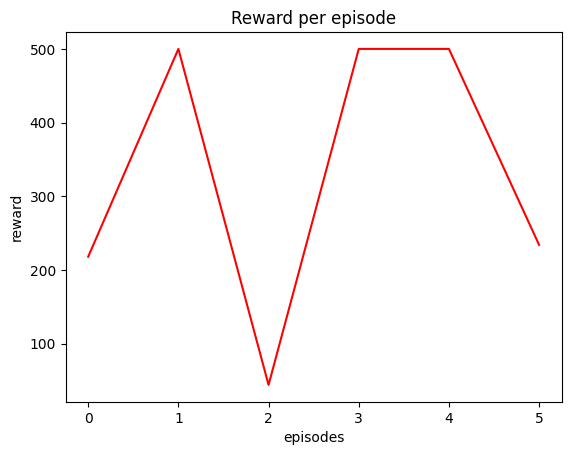

In [60]:
scores = []
state = env.reset()
score = 0
eps = 0
for episode in range(0, 6 ):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break            
        eps = max(eps * EPS_DECAY, 0)
        if score >= 800:
            break
    state = env.reset()        
    scores.append(score)
    score=0

plt.ylabel('reward')
plt.xlabel('episodes')
plt.title("Reward per episode")
plt.plot(scores, color="red")
plt.show()

In [61]:
pickle.dump([scores],open('cartpolev1DQN.pkl', 'wb'))

**Double DQN - CartPole Environemnt**

In [62]:
!pip install gym[classic_control]
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import gym
import math
import random
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")      
device = get_device()
print("Selected Device is : ",device)

env = gym.make('CartPole-v1')

Selected Device is :  cpu


In [64]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, action_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [65]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = ["state", "action", "reward", "next_state", "done"]
    
    def add(self, state, action, reward, next_state, done):
        experience = [state, action, reward, next_state, done]
        self.memory.append(experience)
                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[0])
        states = torch.from_numpy(np.array(tempTensor)).float().to(device)
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[1]])
        actions = torch.from_numpy(np.array(tempTensor)).long().to(device)  
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[2]])
        rewards = torch.from_numpy(np.array(tempTensor)).float().to(device) 
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[3])
        next_states = torch.from_numpy(np.array(tempTensor)).float().to(device)  

        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[4]])
        dones = torch.from_numpy(np.array(tempTensor).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

Double DQN

In [66]:
BUFFER_SIZE = int(1e5)  # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

class DQNAgent:
    action_size = env.action_space.n
    def __init__(self):
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.fixed_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.timestep = 1     
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if ((self.timestep-1) % UPDATE_EVERY) == 0:
            if len(self.memory) > BATCH_SIZE:
                self.learn(self.memory.sample())
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        q_values = self.q_network(states)
        q_expected = q_values.gather(1, actions)
        with torch.no_grad():
            best_actions = self.q_network(next_states).argmax(1).unsqueeze(1)
            q_targets_next = self.fixed_network(next_states).gather(1, best_actions)
            q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.fnetwork_update(self.q_network, self.fixed_network)
        
    def fnetwork_update(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            with torch.no_grad():
                target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
             
    def act(self, state, eps):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()
        if random.random() < eps:
            return np.random.randint(self.action_size)
        else:
            action = action_values.argmax(1).item()
            return action    

In [67]:
MAX_EPISODES = 3000  # Max number of episodes to play
MAX_STEPS = 2000     # Max steps allowed in a single episode/play
PRINT_EVERY = 100    # How often to print the progress
# Epsilon schedule
EPS_START = 1     # Default/starting value of eps
EPS_DECAY = 0.998    # Epsilon decay rate
EPS_MIN = 0.01       # Minimum epsilon 

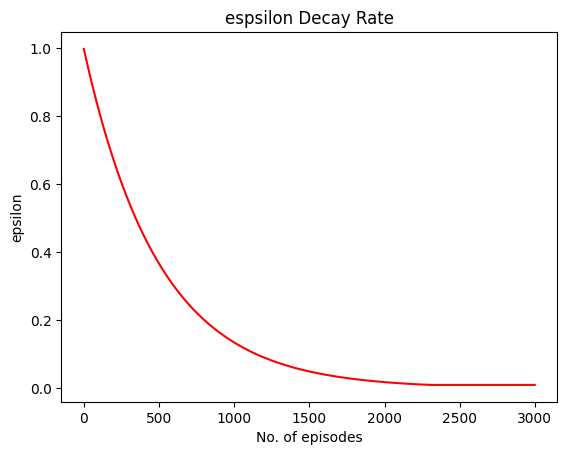

In [68]:
test_eps = EPS_START
eps_list = []
for _ in range(MAX_EPISODES):
          test_eps = max(test_eps * EPS_DECAY, EPS_MIN)
          eps_list.append(test_eps)          

plt.title('espsilon Decay Rate')
plt.xlabel('No. of episodes')
plt.ylabel('epsilon')    
plt.plot(eps_list,color="red")
plt.show()

In [69]:
scores = []
scores_window = deque(maxlen=100)
state = env.reset()
score = 0
eps = EPS_START
dqn_agent = DQNAgent()

for episode in range(1, MAX_EPISODES + 1):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if score >= 500:
            break
    state = env.reset()        
    scores_window.append(score)
    scores.append(score)
    score=0

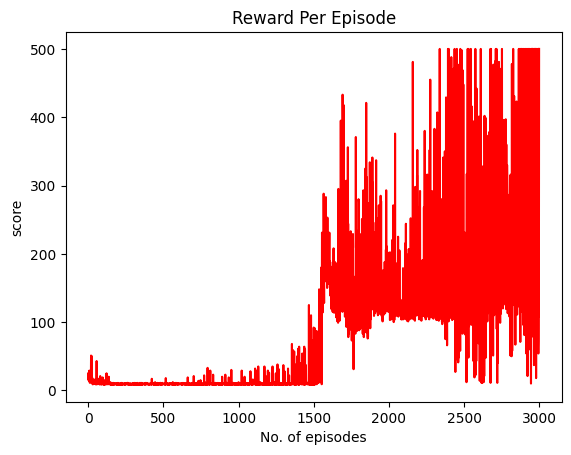

In [70]:
plt.title('Reward Per Episode')
plt.plot(scores,color="red")
plt.xlabel('No. of episodes')
plt.ylabel('score')
plt.show()

In [71]:
scores = []
state = env.reset()
score = 0
eps = 0

for episode in range(0, 5 ):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, 0)
        if score >= 500:
            break
    state = env.reset()        
    scores.append(score)
    score=0

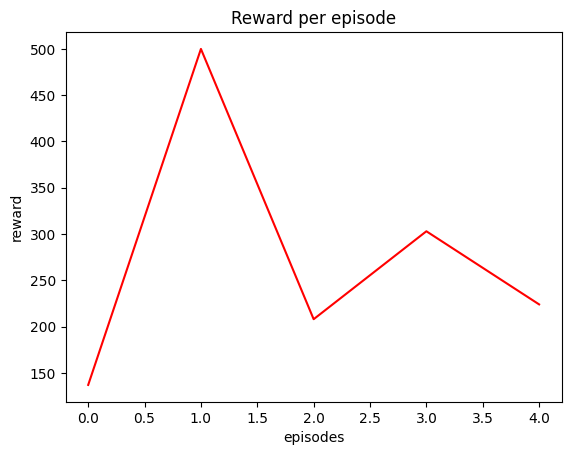

In [72]:
plt.ylabel('reward')
plt.xlabel('episodes')
plt.title("Reward per episode")

plt.plot(scores, color="red")
plt.show()

In [73]:
pickle.dump([scores],open('cartpolev1DoubleDQN.pkl', 'wb'))

**Lunar Lander-v2**

In [74]:
!pip install gym[classic_control]
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import gym
import math
import random
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_device()
print(device)

env = gym.make('LunarLander-v2')

cpu


In [76]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, action_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [77]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = ["state", "action", "reward", "next_state", "done"]
    
    def add(self, state, action, reward, next_state, done):
        experience = [state, action, reward, next_state, done]
        self.memory.append(experience)
                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[0])
        states = torch.from_numpy(np.array(tempTensor)).float().to(device)
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[1]])
        actions = torch.from_numpy(np.array(tempTensor)).long().to(device)  
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[2]])
        rewards = torch.from_numpy(np.array(tempTensor)).float().to(device) 
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[3])
        next_states = torch.from_numpy(np.array(tempTensor)).float().to(device)  

        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[4]])
        dones = torch.from_numpy(np.array(tempTensor).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [78]:
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64        
GAMMA = 0.99           
TAU = 1e-3            
LR = 1e-4              
UPDATE_EVERY = 4      
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

class DQNAgent:
    def __init__(self):
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.fixed_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.timestep = 1
        
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if ((self.timestep-1) % UPDATE_EVERY) == 0:
            if len(self.memory) > BATCH_SIZE:
                self.learn(self.memory.sample())
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        action_values = self.fixed_network(next_states).detach()
        Q_target = rewards + (GAMMA * action_values.max(1)[0].unsqueeze(1) * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.fnetwork_update(self.q_network, self.fixed_network)
        
    def fnetwork_update(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            with torch.no_grad():
                target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        
    def act(self, state, eps):
        if random.random() < eps:
            return np.random.randint(action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    

In [79]:
MAX_EPISODES = 1000  
MAX_STEPS = 1000     
PRINT_EVERY = 100  
EPS_START = 1.0     
EPS_DECAY = 0.999   
EPS_MIN = 0.01      

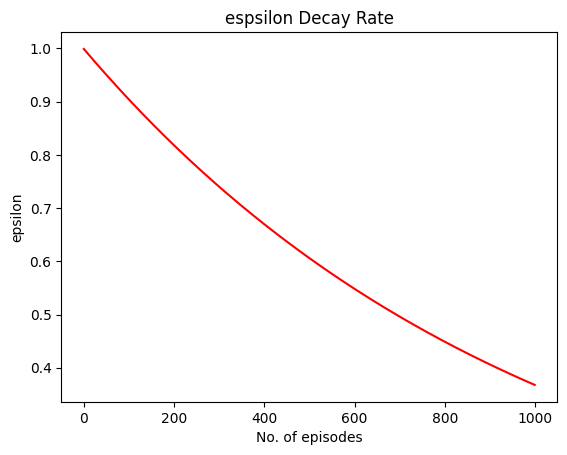

In [80]:
test_eps = EPS_START
eps_list = []
for _ in range(MAX_EPISODES):
          test_eps = max(test_eps * EPS_DECAY, EPS_MIN)
          eps_list.append(test_eps)          

plt.title('espsilon Decay Rate')
plt.xlabel('No. of episodes')
plt.ylabel('epsilon')    
plt.plot(eps_list,color="red")
plt.show()

In [81]:
scores = []
scores_window = deque(maxlen=100)
state = env.reset()
score = 0
eps = EPS_START

dqn_agent = DQNAgent()

for episode in range(1, MAX_EPISODES + 1):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if score >= 200:
            break
    state = env.reset()        
    scores_window.append(score)
    scores.append(score)
    score=0 

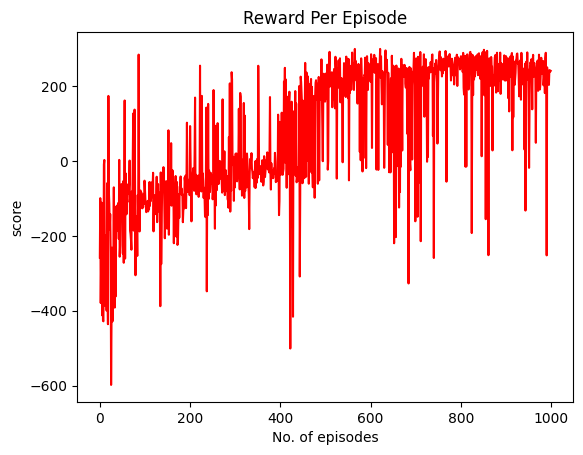

In [82]:
plt.title('Reward Per Episode')
plt.plot(scores,color="red")
plt.xlabel('No. of episodes')
plt.ylabel('score')
plt.show()

In [83]:
scores = []
state = env.reset()
score = 0
eps = 0

for episode in range(0, 6 ):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, 0)
        if score >= 200:
            break
    state = env.reset()        
    scores.append(score)
    score=0   

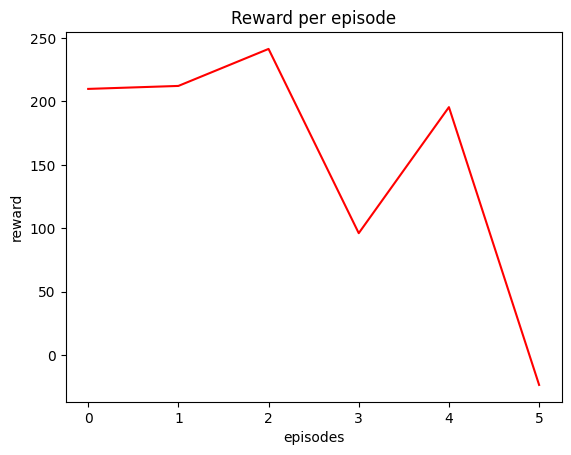

In [84]:
plt.ylabel('reward')
plt.xlabel('episodes')
plt.title("Reward per episode")
plt.plot(scores, color="red")
plt.show()

In [85]:
pickle.dump([scores],open('LunarLanderv2DQN.pkl', 'wb'))

Double DQN - Lunar Lander Environemnt

In [86]:
!pip install gym[classic_control]
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import gym
import math
import random
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_device()
print(device)

env = gym.make('LunarLander-v2')

cpu


In [88]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, action_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [89]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = ["state", "action", "reward", "next_state", "done"]
    
    def add(self, state, action, reward, next_state, done):
        experience = [state, action, reward, next_state, done]
        self.memory.append(experience)
                
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[0])
        states = torch.from_numpy(np.array(tempTensor)).float().to(device)
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[1]])
        actions = torch.from_numpy(np.array(tempTensor)).long().to(device)  
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[2]])
        rewards = torch.from_numpy(np.array(tempTensor)).float().to(device) 
        
        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append(ex[3])
        next_states = torch.from_numpy(np.array(tempTensor)).float().to(device)  

        tempTensor=[]
        for ex in experiences:
          if(ex != None):
            tempTensor.append([ex[4]])
        dones = torch.from_numpy(np.array(tempTensor).astype(np.uint8)).float().to(device)             
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

Double DQN

In [90]:
BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64         
GAMMA = 0.99            
TAU = 1e-3              
LR = 1e-4               
UPDATE_EVERY = 4        
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

class DQNAgent:
    action_size = env.action_space.n
    def __init__(self):
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.fixed_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.timestep = 1
           
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if ((self.timestep-1) % UPDATE_EVERY) == 0:
            if len(self.memory) > BATCH_SIZE:
                self.learn(self.memory.sample())
        
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        q_values = self.q_network(states)
        q_expected = q_values.gather(1, actions)
        with torch.no_grad():
            best_actions = self.q_network(next_states).argmax(1).unsqueeze(1)
            q_targets_next = self.fixed_network(next_states).gather(1, best_actions)
            q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.fnetwork_update(self.q_network, self.fixed_network)
        
    def fnetwork_update(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            with torch.no_grad():
                target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        
    def act(self, state, eps):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()
        if random.random() < eps:
            return np.random.randint(self.action_size)
        else:
            action = action_values.argmax(1).item()
            return action    


In [91]:
MAX_EPISODES = 1000  
MAX_STEPS = 1000    
PRINT_EVERY = 100   
EPS_START = 1.0     
EPS_DECAY = 0.999   
EPS_MIN = 0.01      

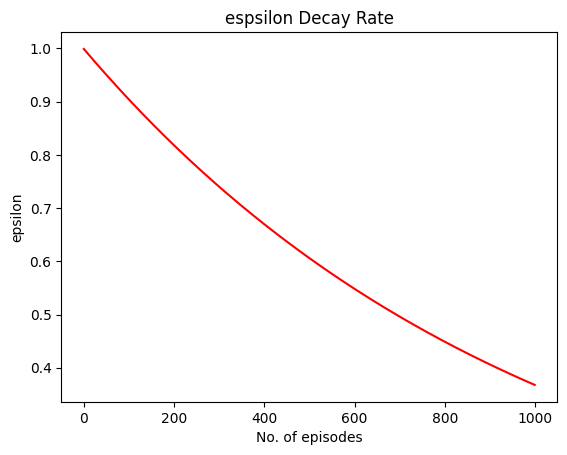

In [92]:
test_eps = EPS_START
eps_list = []
for _ in range(MAX_EPISODES):
          test_eps = max(test_eps * EPS_DECAY, EPS_MIN)
          eps_list.append(test_eps)          

plt.title('espsilon Decay Rate')
plt.xlabel('No. of episodes')
plt.ylabel('epsilon')    
plt.plot(eps_list,color="red")
plt.show()

In [93]:
scores = []
scores_window = deque(maxlen=100)
state = env.reset()
score = 0
eps = EPS_START

dqn_agent = DQNAgent()

for episode in range(1, MAX_EPISODES + 1):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if score >= 200:
             break
    state = env.reset()        
    scores_window.append(score)
    scores.append(score)
    score=0

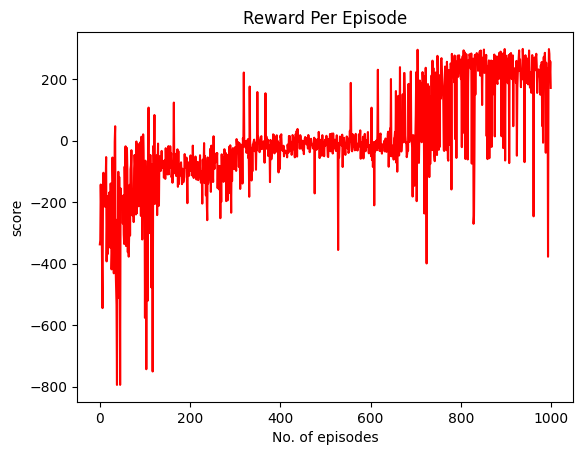

In [94]:
plt.title('Reward Per Episode')
plt.plot(scores,color="red")
plt.xlabel('No. of episodes')
plt.ylabel('score')
plt.show()

In [95]:
scores = []
state = env.reset()
score = 0
eps = 0

for episode in range(0, 6 ):
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, 0)
        if score >= 200:
            break
    state = env.reset()        
    scores.append(score)
    score=0

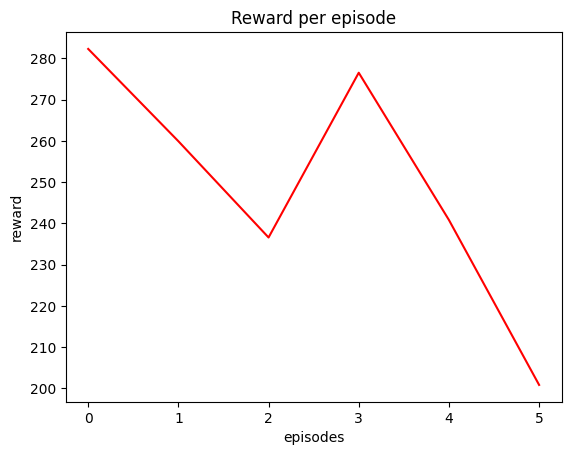

In [96]:
plt.ylabel('reward')
plt.xlabel('episodes')
plt.title("Reward per episode")

plt.plot(scores, color="red")
plt.show()

In [97]:
import pickle
pickle.dump([scores],open('LunarLanderv2DoubleDQN.pkl', 'wb'))